# Hierarchical Partial Pooling

**[Original tutorial](https://docs.pymc.io/notebooks/hierarchical_partial_pooling.html)**

Estimate batting average of several players, but they each have a different number of at-bats.

## Approach

We will use PyMC3 to estimate the batting average for 18 baseball players ([Efron and Morris](http://www.swarthmore.edu/NatSci/peverso1/Sports%20Data/JamesSteinData/Efron-Morris%20Baseball/EfronMorrisBB.txt).
Having estimated the averages across all players, we will then estimate the batting average of a new player with 4 at-bats and no hits.

We will use a hierarhcical structure to share batting average information across players.

In [3]:
import arviz as az
import janitor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import theano.tensor as tt

gg.theme_set(gg.theme_minimal)
%config InlineBackend.figure_format = "retina"
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

## Data

In [5]:
data = pd.read_csv(pm.get_data("efron-morris-75-data.tsv"), sep="\t").clean_names()
data

,firstname,lastname,at_bats,hits,battingaverage,remainingat_bats,remainingaverage,seasonat_bats,seasonhits,seasonaverage
0,Roberto,Clemente,45,18,0.400,367,0.3460,412,145,0.352
1,Frank,Robinson,45,17,0.378,426,0.2981,471,144,0.306
2,Frank,Howard,45,16,0.356,521,0.2764,566,160,0.283
3,Jay,Johnstone,45,15,0.333,275,0.2218,320,76,0.238
4,Ken,Berry,45,14,0.311,418,0.2727,463,128,0.276
5,Jim,Spencer,45,14,0.311,466,0.2704,511,140,0.274
6,Don,Kessinger,45,13,0.289,586,0.2645,631,168,0.266
7,Luis,Alvarado,45,12,0.267,138,0.2101,183,41,0.224
8,Ron,Santo,45,11,0.244,510,0.2686,555,148,0.267
9,Ron,Swaboda,45,11,0.244,200,0.2300,245,57,0.233


## Model

We will assume there exists a hidden factor $\phi \in [0, 1]$ related to the expected performance for all players.
We know nothing about this value and will thus us an uninformative prior: $\phi \sim \text{Uniform}(0, 1)$.

Another hyperparameter $\kappa$ will account for the variance in the population of batting averages.
We will use a bounded Pareto distribution as a prior to ensure the estimated value falls within a reasonable range.
However, the Pareto distribution is difficult to sample, so will use a simple trick based on the fact that the log of a Pareto distributed random variable follows an exponential distirbution.

Both of these hyperparameters will be used to parameterize a Beta distribution because it is ideal for modeling quantities on the unit interval $[0, 1]$.
Usually, the Beta distribution is parameterized via a scale and shape parameter, but it can also be parameterized in terms of its mean $\mu \in [0, 1]$ and sample size (as a proxy for variance): $\nu = \alpha + \beta(\nu > 0)$.

Finally, the sampling distribution will be a Binomial where each player either hit or missed at each at-bat.

In [57]:
at_bats, hits = data[["at_bats", "hits"]].to_numpy().T
N = len(hits)

with pm.Model() as baseball_model:

    at_bats_shared = pm.Data("at_bats", data.at_bats.values)
    hits_shared = pm.Data("hits", data.hits.values)

    ϕ = pm.Uniform("ϕ", lower=0.0, upper=1.0)

    κ_log = pm.Exponential("κ_log", lam=1.5)
    κ = pm.Deterministic("κ", tt.exp(κ_log))

    θ = pm.Beta("θ", alpha=ϕ * κ, beta=(1.0 - ϕ) * κ, shape=N)

    y = pm.Binomial("y", n=at_bats_shared, p=θ, observed=hits_shared)

    θ_new = pm.Beta("θ_new", alpha=ϕ * κ, beta=(1.0 - ϕ) * κ)
    y_new = pm.Binomial("y_new", n=4, p=θ_new, observed=0)

    trace = pm.sample(
        2000,
        init="advi",
        n_init=10000,
        tune=2500,
        chains=2,
        cores=2,
        target_accept=0.95,
        random_seed=RANDOM_SEED,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 7100
Interrupted at 7,099 [70%]: Average Loss = 115.6
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ_new, θ, κ_log, ϕ]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


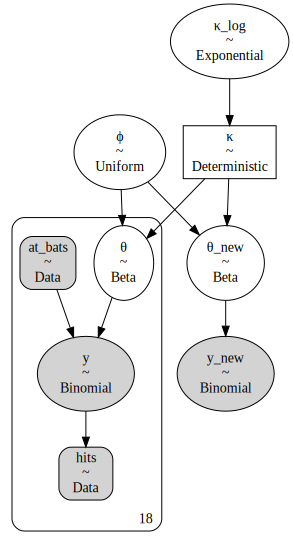

In [58]:
pm.model_to_graphviz(baseball_model)

In [59]:
trace_az = az.from_pymc3(trace=trace, model=baseball_model)

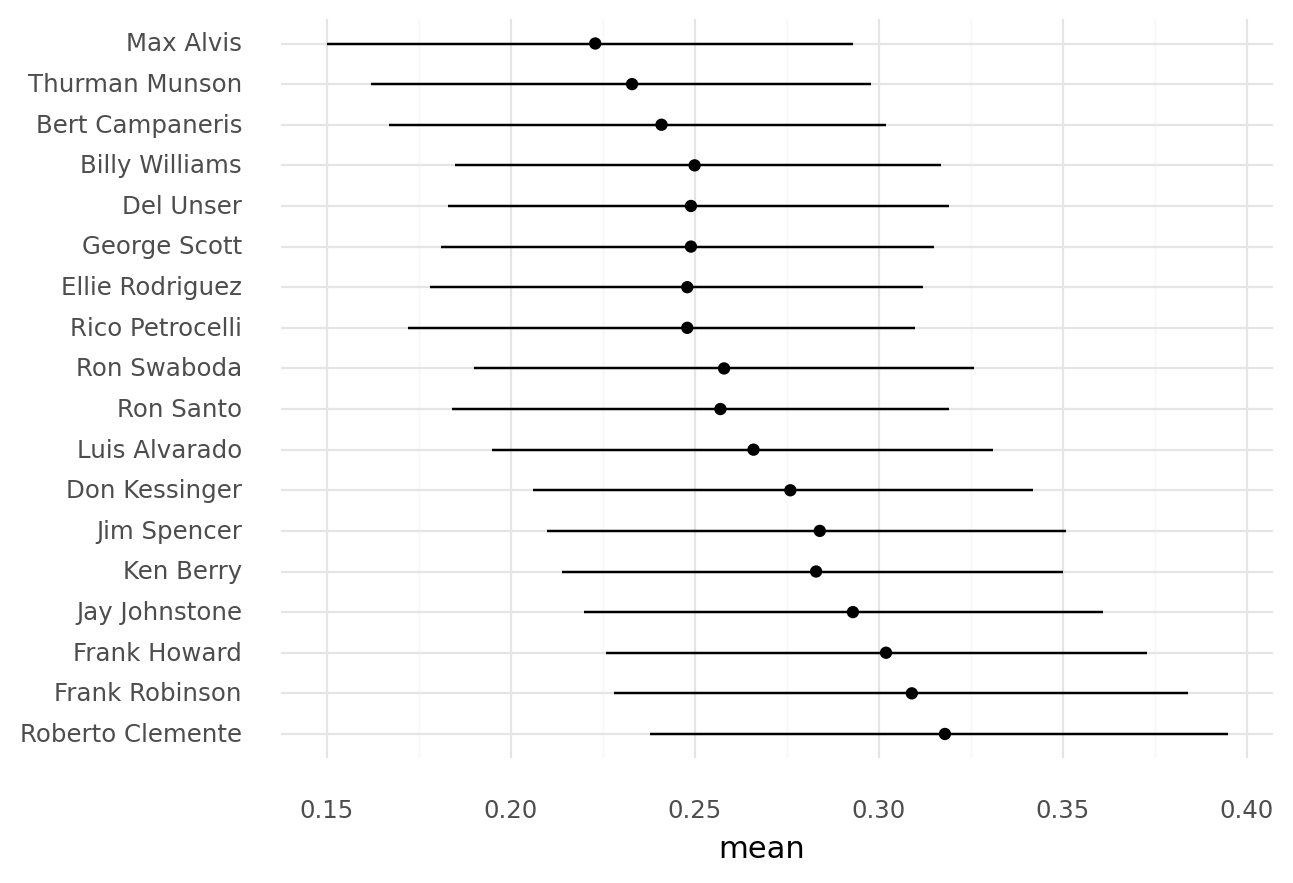

<ggplot: (365291653)>

In [60]:
theta_post = az.summary(trace_az, var_names="θ", hdi_prob=0.89)
theta_post["player"] = [f + " " + l for f, l in zip(data.firstname, data.lastname)]
theta_post["player"] = pd.Categorical(
    theta_post.player.values, categories=theta_post.player.values, ordered=True
)

(
    gg.ggplot(theta_post, gg.aes(x="player", y="mean"))
    + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"))
    + gg.geom_point()
    + gg.coord_flip()
    + gg.theme(axis_title_y=gg.element_blank())
)

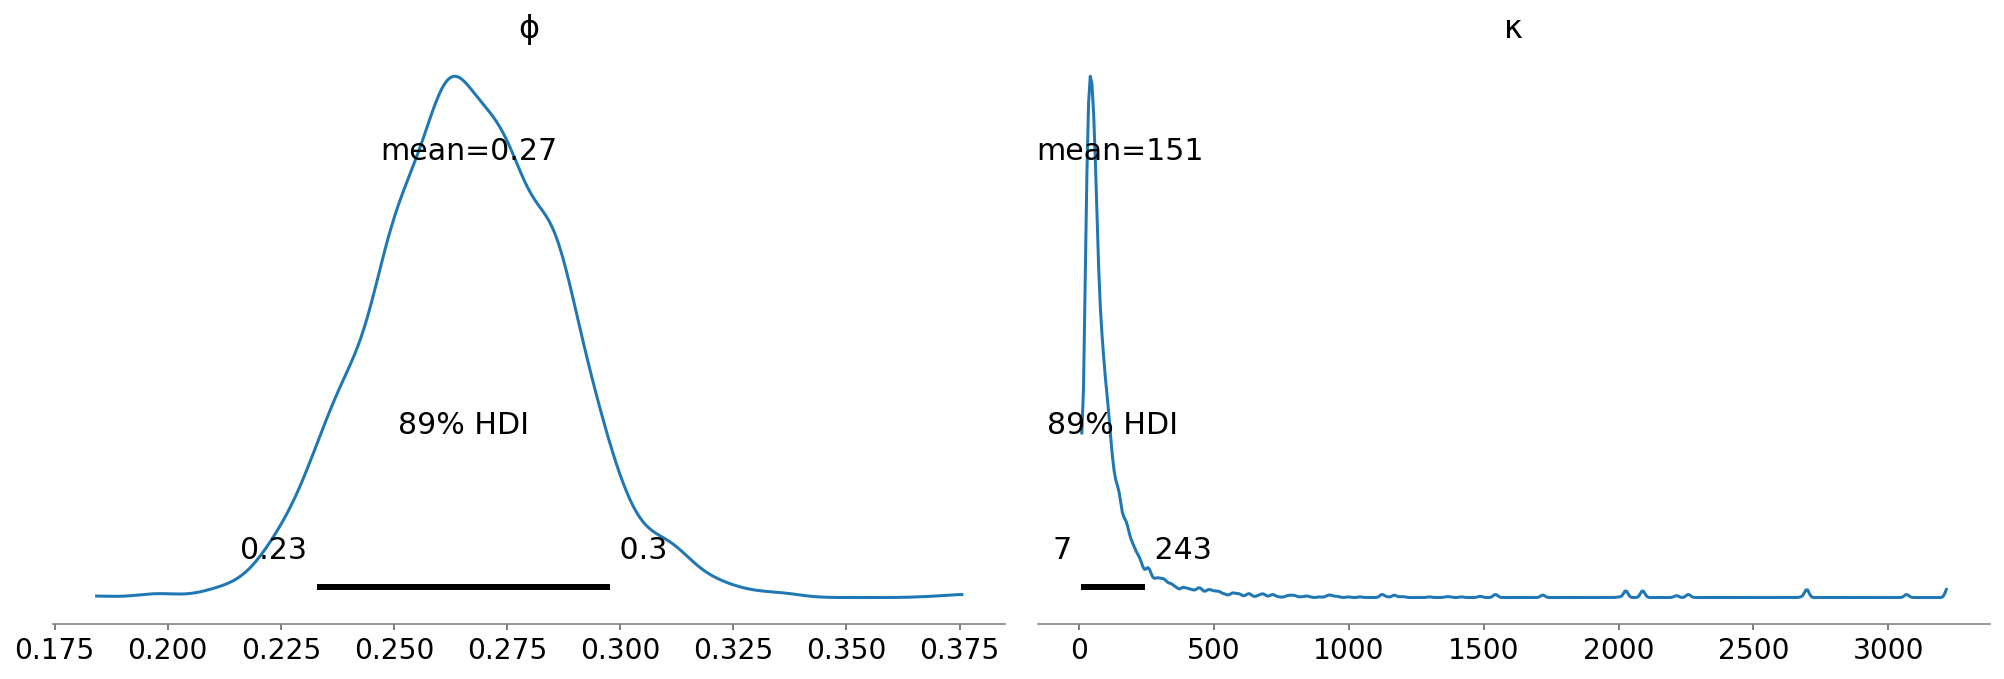

In [61]:
az.plot_posterior(trace_az, var_names=["ϕ", "κ"], hdi_prob=0.89)
plt.show()

In [62]:
with baseball_model:
    ppc = pm.sample_posterior_predictive(trace=trace, samples=100)

/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/pymc3/sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample


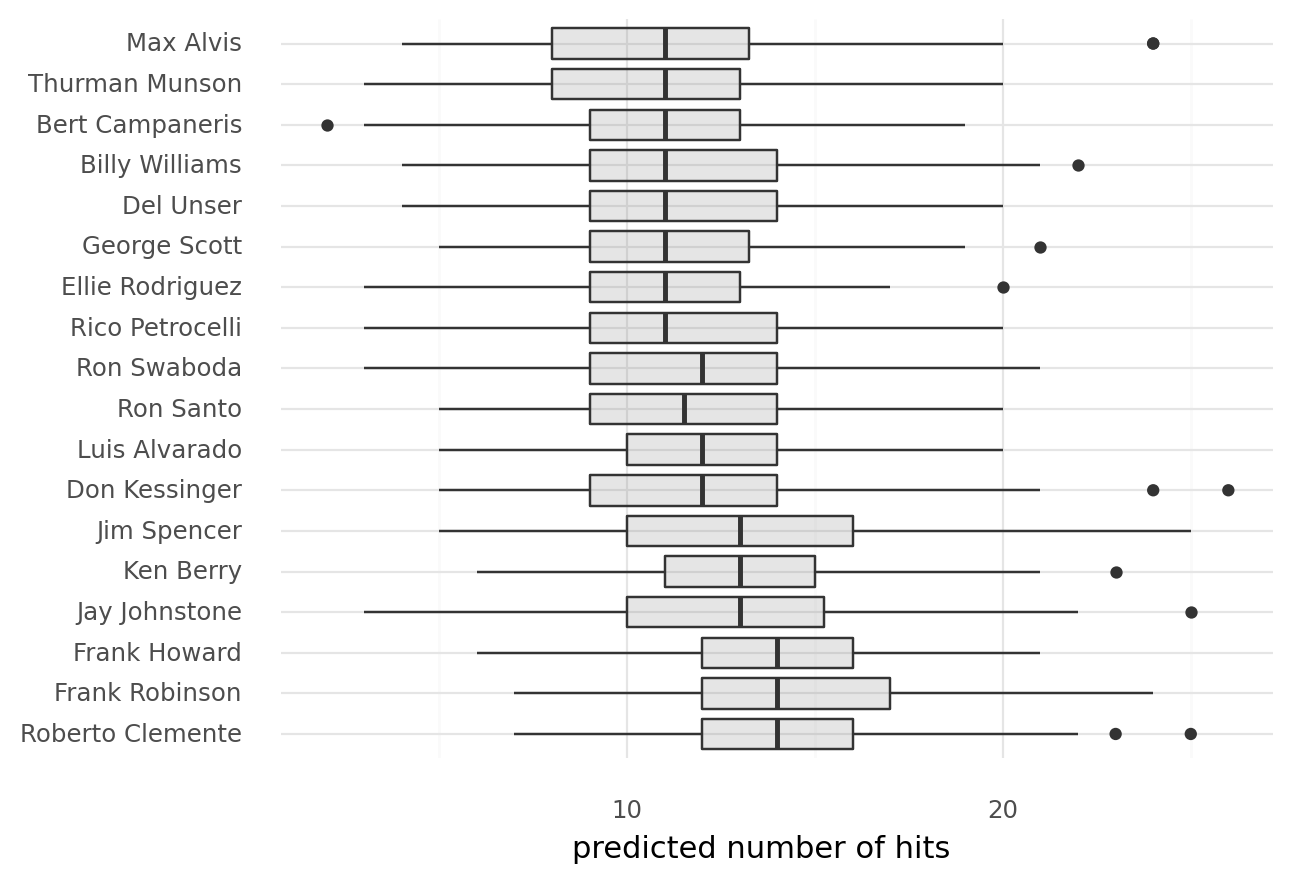

<ggplot: (363772260)>

In [63]:
ppc_df = pd.DataFrame(ppc["y"], columns=theta_post.player).melt()
ppc_df["player"] = pd.Categorical(ppc_df.player, categories=theta_post.player)

(
    gg.ggplot(ppc_df, gg.aes(x="player", y="value"))
    + gg.geom_boxplot(fill="grey", alpha=0.2)
    + gg.coord_flip()
    + gg.theme(axis_title_y=gg.element_blank())
    + gg.labs(y="predicted number of hits")
)

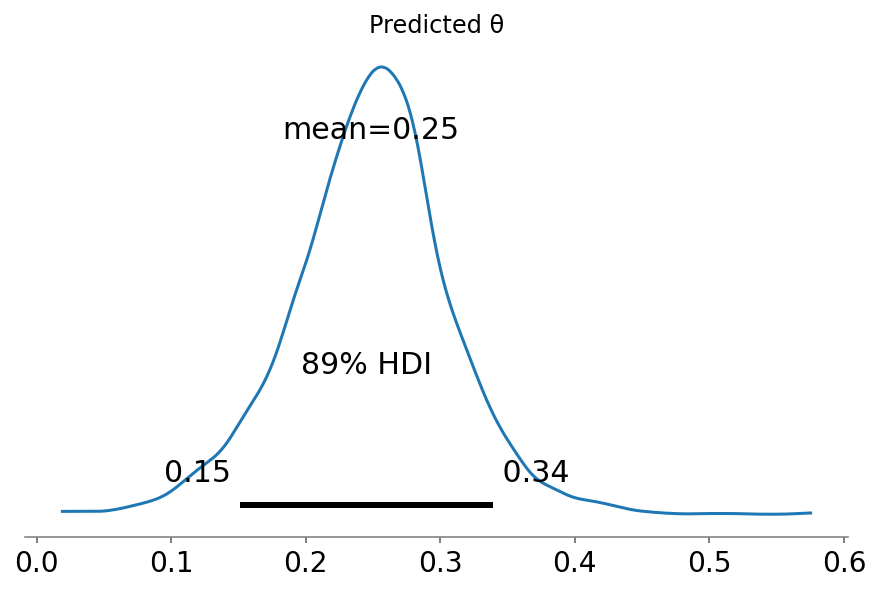

In [67]:
ax = az.plot_posterior(trace_az, var_names="θ_new", hdi_prob=0.89)
ax.set_title("Predicted θ")
plt.show()

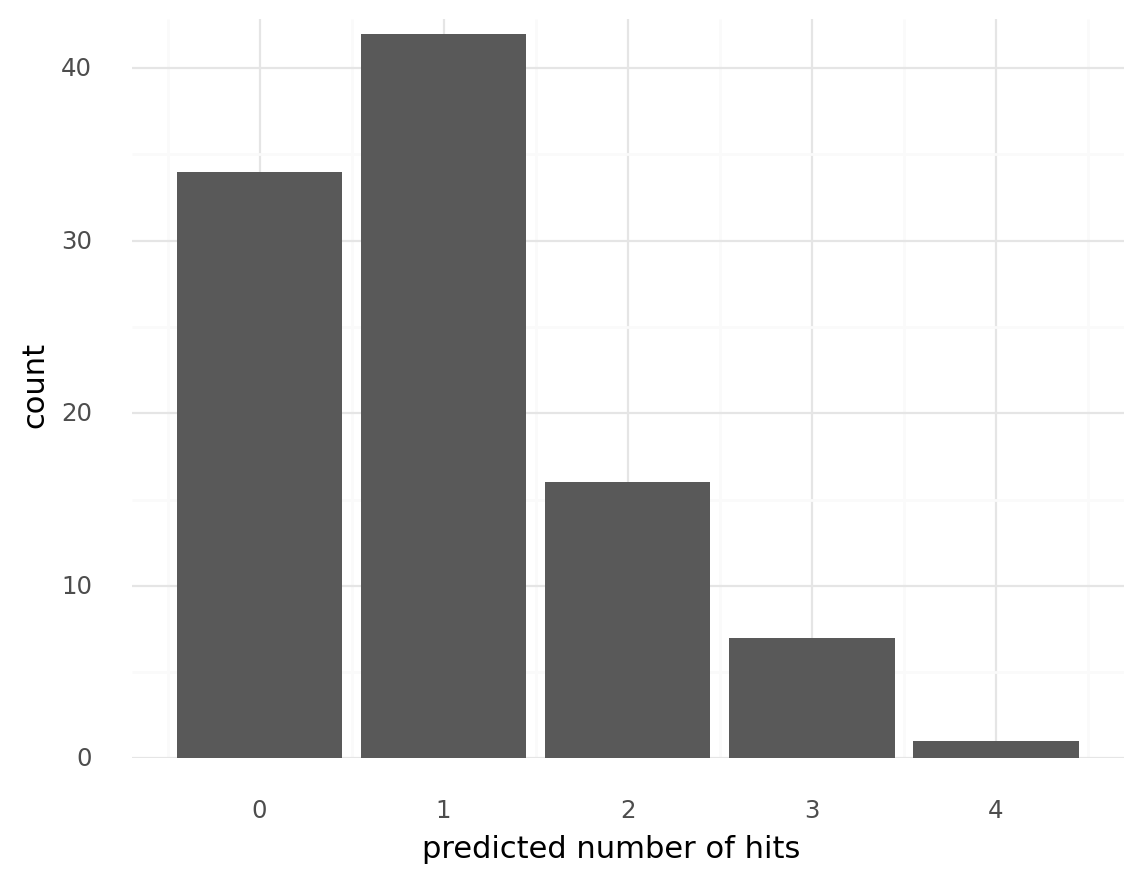

<ggplot: (363210882)>

In [75]:
(
    gg.ggplot(pd.DataFrame({"pred": ppc["y_new"]}), gg.aes(x="pred"))
    + gg.geom_bar()
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.labs(x="predicted number of hits")
)

---

In [76]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Feb 08 2021

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.20.0

arviz     : 0.11.0
theano    : 1.0.5
numpy     : 1.20.0
pandas    : 1.2.1
plotnine  : 0.7.1
pymc3     : 3.9.3
janitor   : 0.20.10
matplotlib: 3.3.4

Watermark: 2.1.0

